# Skilled Nursing Facility Violations

In [251]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


import warnings
warnings.filterwarnings("ignore")

In [280]:
#Helper function for cleaner graphing!
def create_histogram(df, column_name, title):
    '''
    Input dataframe & column name.
    Outputs histogram styled for project
    '''
    #styling
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = 'Helvetica'
    plt.figure(figsize=(10, 5))
    #graph
    plt.hist(df[column_name], color = '#3C4F76', bins=100)
    #titling
    plt.xlabel('Percentage', fontsize=12, fontweight='black', color = '#333F4B')
    plt.ylabel('Count of Reports',fontsize=12, fontweight='black', color = '#333F4B')
    plt.title(title.title(), fontsize=15, fontweight='black', color = '#333F4B', pad=10)
    return plt

## Importing Data

It's necessary to separate out the long-stay and short-stay residents since they have separate measures. I'd expect they would also have very different outcomes in this data since they have different experiences within the Skilled Nursing Facilities. 

For the purposes of this analysis, I'll be focusing on long-stay patients.

In [191]:
class import_and_clean:
    '''
    Imports CMS data from csv and cleans data.
    
    Class inputs are data_location, data_year, and the resident type (short-term vs long term)
    '''
    def __init__(self, data_location, data_year, resident_type):
        self.data_location = data_location
        self.year = data_year
        self.resident_type = resident_type
        
    def read_file(self):
        df = pd.read_csv(self.data_location, encoding='cp1252', dtype={'Federal Provider Number': 'str'})

        #Separating out residents by group: Long vs Short-stay patients
        stay = df[df['Measure Description'].str.contains(self.resident_type)]

        #Remove currently unnecessary fields
        stay = stay[['Federal Provider Number', 'Provider Name', 'Measure Code','Measure Description',
                     'Q1 Measure Score','Q2 Measure Score','Q3 Measure Score','Q4 Measure Score','Four Quarter Average Score']]

        #Combine description & code into one field for ease of use
        stay['code_description'] = stay['Measure Code'].astype(str) + ' ' + ls['Measure Description']

        return stay

In [192]:
details = import_and_clean('data/NH_QualityMsr_MDS_Apr2022.csv', '2021', 'long-stay')
df = details.read_file()

In [ ]:
def pivot_quarters(df, quarter, year):
    '''
    Pivot data from long to wide format
    '''
    #set filter for quarter based on input
    quarter_filter = 'Four Quarter Average Score'
    #pivot
    pivot_df = pd.pivot(df, columns = ['code_description'], 
                        index = ['Federal Provider Number','Provider Name'], 
                        values = [quarter_filter])
    #reset column names & add new columns
    pivot_df.columns = pivot_df.columns.get_level_values(1)
    pivot_df = pivot_df.reset_index()
    pivot_df['Quarter'] = quarter.upper()
    pivot_df['Year'] = year
    return pivot_df

all_quart = pivot_quarters(df, 'Four Quarter Average Score', '2021')

In [367]:
#load provider info
prov_df = pd.read_csv('data/NH_ProviderInfo_Apr2021.csv',encoding='cp1252')

In [413]:
prov_df = prov_df[['Federal Provider Number','Provider Address',
       'Provider City', 'Provider State', 'Provider Zip Code',
       'Provider County Name', 'Ownership Type', 'Number of Certified Beds',
       'Average Number of Residents per Day','Provider Type',
       'Provider Resides in Hospital', 'Date First Approved to Provide Medicare and Medicaid Services',
       'Continuing Care Retirement Community', 'Special Focus Status',
       'Abuse Icon', 'Most Recent Health Inspection More Than 2 Years Ago',
       'Provider Changed Ownership in Last 12 Months',
       'With a Resident and Family Council','Overall Rating','Health Inspection Rating',
       'Staffing Rating', 'RN Staffing Rating', 
       'Reported Nurse Aide Staffing Hours per Resident per Day',
       'Reported LPN Staffing Hours per Resident per Day',
       'Reported RN Staffing Hours per Resident per Day',
       'Reported Licensed Staffing Hours per Resident per Day',
       'Reported Total Nurse Staffing Hours per Resident per Day',
       'Reported Physical Therapist Staffing Hours per Resident Per Day',
       'Case-Mix Nurse Aide Staffing Hours per Resident per Day',
       'Case-Mix LPN Staffing Hours per Resident per Day',
       'Case-Mix RN Staffing Hours per Resident per Day',
       'Case-Mix Total Nurse Staffing Hours per Resident per Day',
       'Adjusted Nurse Aide Staffing Hours per Resident per Day',
       'Adjusted LPN Staffing Hours per Resident per Day',
       'Adjusted RN Staffing Hours per Resident per Day',
       'Adjusted Total Nurse Staffing Hours per Resident per Day',
       'Number of Facility Reported Incidents',
       'Number of Substantiated Complaints',
       'Number of Citations from Infection Control Inspections',
       'Number of Fines', 'Total Amount of Fines in Dollars','Total Number of Penalties']]

In [414]:
prov_df['Federal Provider Number']= prov_df['Federal Provider Number'].astype(str)

In [415]:
# I decided to keep only facilities that had values in both data sets
# This removed 64 facilities
all_measures = all_quart.merge(prov_df, on = 'Federal Provider Number', how = 'inner')

## Investigating Data

Looking at the data information below, there are more instances of measure scores as the quarters progress (example: Q1 Measure Score has 182,661 non-null objects while Q4 Measure Score has 185,900). This could be due to more skilled nursing facilities being added to CMS database as the year went on, but this will need to be investigated further.

There are no nulls in the many of the data columns so at first glance, this looks like a very well maintained database which is a good sign.

In [416]:
all_measures.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15139 entries, 0 to 15138
Data columns (total 59 columns):
 #   Column                                                                                                 Non-Null Count  Dtype  
---  ------                                                                                                 --------------  -----  
 0   Federal Provider Number                                                                                15139 non-null  object 
 1   Provider Name                                                                                          15139 non-null  object 
 2   401 Percentage of long-stay residents whose need for help with daily activities has increased          14632 non-null  float64
 3   404 Percentage of long-stay residents who lose too much weight                                         14683 non-null  float64
 4   405 Percentage of low risk long-stay residents who lose control of their bowels or bladder    

Measures 406, 407, 409, and 410 are reported very infrequently based on the summary statistics below. However, there are some facilities based on this data that are seeing a good number of these issues so I don't want to totally eliminate the columns yet.

In [417]:
all_measures.describe()

401 Percentage of long-stay residents whose need for help with daily activities has increased  \
count                                       14632.000000                                               
mean                                           14.841888                                               
std                                             6.795640                                               
min                                             0.000000                                               
25%                                            10.094637                                               
50%                                            14.285716                                               
75%                                            19.021738                                               
max                                            63.636360                                               

       404 Percentage of long-stay residents who lose too much weight  \
count                                       14683.000000                
mean                                            6.285475                
std                                             3.852442                
min                                             0.000000                
25%                                             3.571429                
50%                                             5.785125                
75%                                             8.333335                
max                                            44.347824                

       405 Percentage of low risk long-stay residents who lose control of their bowels or bladder  \
count                                       14151.000000                                            
mean                                           47.009018                                            
std                                            17.905278                                            
min                                             0.000000                                            
25%                                            34.729532                                            
50%                                            47.058822                                            
75%                                            59.090908                                            
max                                           100.000000                                            

       406 Percentage of long-stay residents with a catheter inserted and left in their bladder  \
count                                       14705.000000                                          
mean                                            1.526194                                          
std                                             1.839692                                          
min                                             0.000000                                          
25%                                             0.294744                                          
50%                                             1.000612                                          
75%                                             2.108500                                          
max                                            33.871746                                          

       407 Percentage of long-stay residents with a urinary tract infection  \
count                                       14720.000000                      
mean                                            2.385768                      
std                                             2.627828                      
min                                             0.000000                      
25%                                             0.564971                      
50%                                             1.602197                      
75%                                             3.303923 

In [420]:
all_measures.shape

(15139, 59)

There are quite a few missing values out of the 15,203 reports. What this means will need to be investigated.

In [421]:
all_measures.isnull().sum().sort_values()

Federal Provider Number                                                                                      0
Provider Zip Code                                                                                            0
Provider County Name                                                                                         0
Ownership Type                                                                                               0
Number of Certified Beds                                                                                     0
Provider Type                                                                                                0
Provider Resides in Hospital                                                                                 0
Date First Approved to Provide Medicare and Medicaid Services                                                0
Total Amount of Fines in Dollars                                                                             0
A

One of the first thing that stood out to me was the fact that many of the categories had a lot of zeros. For a measure like depressive symptoms, there would seem to be a low probability that there could actually be a facility where no one has any symptoms at all of depression considering it is such a prevalent condition.

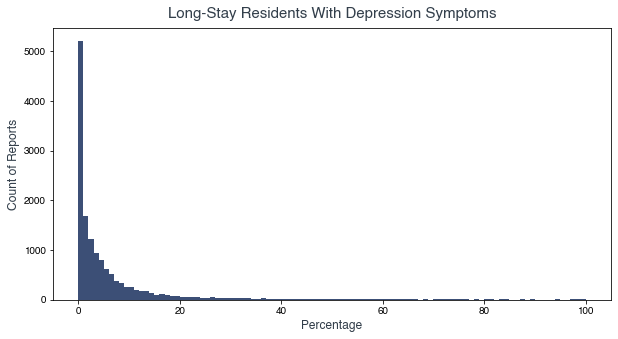

In [424]:
examp = create_histogram(all_measures, 
                         '408 Percentage of long-stay residents who have depressive symptoms', 
                         'Long-Stay Residents with Depression Symptoms')

Depression has is far more left-scewed than many of the other measures

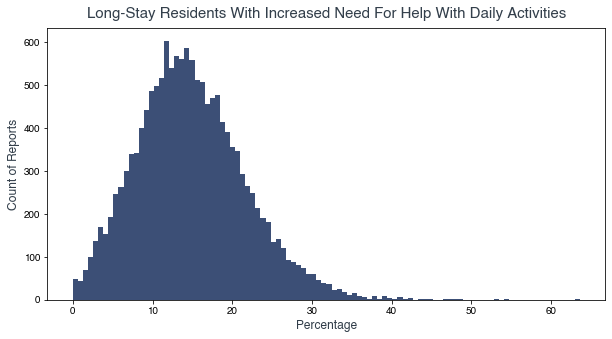

In [425]:
examp = create_histogram(all_measures, 
                         '401 Percentage of long-stay residents whose need for help with daily activities has increased', 
                         'Long-Stay Residents with Increased Need for Help with Daily Activities')

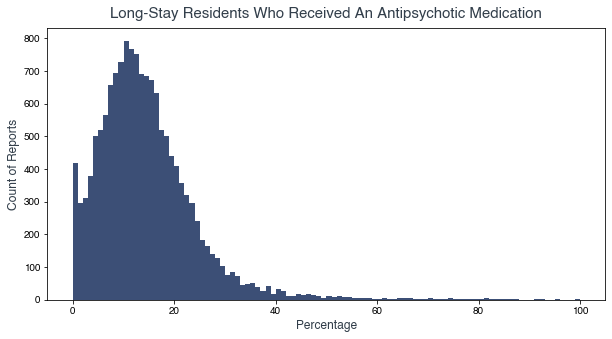

In [426]:
examp = create_histogram(all_measures, 
                         '419 Percentage of long-stay residents who received an antipsychotic medication', 
                         'long-stay residents who received an antipsychotic medication')

We see the same trend with measurements around weight-loss. 

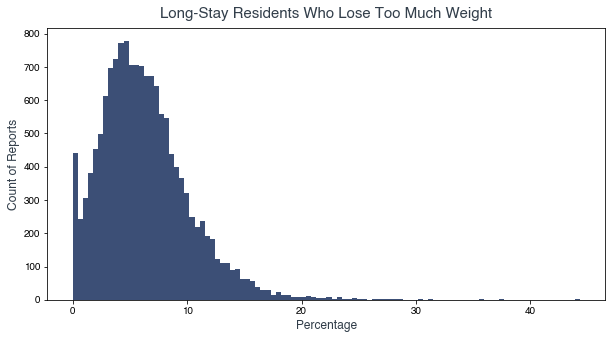

In [427]:
examp = create_histogram(all_measures, 
                         '404 Percentage of long-stay residents who lose too much weight', 
                         'long-stay residents who lose too much weight')

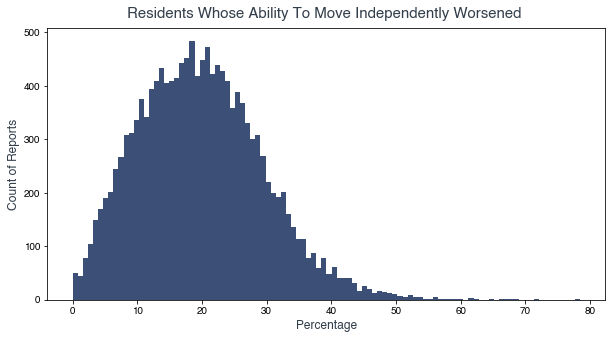

In [428]:
examp = create_histogram(all_measures, 
                         '451 Percentage of long-stay residents whose ability to move independently worsened', 
                         'residents whose ability to move independently worsened ')

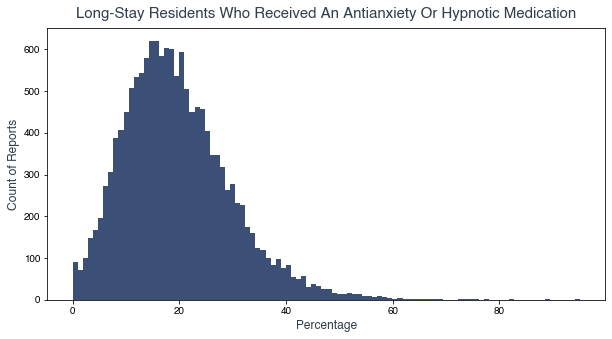

In [429]:
examp = create_histogram(all_measures, 
                         '452 Percentage of long-stay residents who received an antianxiety or hypnotic medication', 
                         'long-stay residents who received an antianxiety or hypnotic medication')

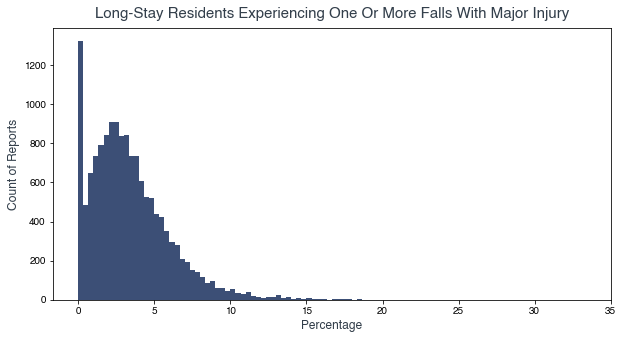

In [430]:
examp = create_histogram(all_measures, 
                         '410 Percentage of long-stay residents experiencing one or more falls with major injury', 
                         'long-stay residents experiencing one or more falls with major injury')

In [431]:
print(str(round((all_quart[all_quart['408 Percentage of long-stay residents who have depressive symptoms']<1].shape[0] 
      / all_quart.shape[0]) * 100)) + '% of reports on depressive symptoms reported less than 1%.')

34% of reports on depressive symptoms reported less than 1%.


In [434]:
#When we eliminate the depressive symptoms with 0, we don't see much of a improvement in it's correlations 
#which is curious to me. We do see a stronger correlation with 
allq_test = all_quart[all_quart['408 Percentage of long-stay residents who have depressive symptoms']>=1]
allq_test.corr()

code_description                                    401 Percentage of long-stay residents whose need for help with daily activities has increased  \
code_description                                                                                                                                    
401 Percentage of long-stay residents whose nee...                                           1.000000                                               
404 Percentage of long-stay residents who lose ...                                           0.139416                                               
405 Percentage of low risk long-stay residents ...                                           0.044660                                               
406 Percentage of long-stay residents with a ca...                                           0.079076                                               
407 Percentage of long-stay residents with a ur...                                           0.112948                                               
408 Percentage of long-stay residents who have ...                                          -0.030167                                               
409 Percentage of long-stay residents who were ...                                           0.014370                                               
410 Percentage of long-stay residents experienc...                                           0.118769                                               
415 Percentage of long-stay residents assessed ...                                          -0.150508                                               
419 Percentage of long-stay residents who recei...                                           0.093967                                               
451 Percentage of long-stay residents whose abi...                                           0.568901                                               
452 Percentage of long-stay residents who recei...                                           0.088287                                               
453 Percentage of high risk long-stay residents...                                           0.079185                                               
454 Percentage of long-stay residents assessed ...                                          -0.102212                                               

code_description                                    404 Percentage of long-stay residents who lose too much weight  \
code_description                                                                                                     
401 Percentage of long-stay residents whose nee...                                           0.139416                
404 Percentage of long-stay residents who lose ...                                           1.000000                
405 Percentage of low risk long-stay residents ...                                           0.090261                
406 Percentage of long-stay residents with a ca...                                           0.036245                
407 Percentage of long-stay residents with a ur...                                           0.083437                
408 Percentage of long-stay residents who have ...                                           0.013745                
409 Percentage of long-stay residents who were ...                                           0.023154                
410 Percentage of long-stay residents experienc...                                           0.097009                
415 Percentage of long-stay residents assessed ...                                          -0.080348                
419 Percentage of long-stay residents who recei...                                          -0.006159                
451 Percentage of long-stay residents whose abi...                                           0.167111                
452 Percentage of long-stay residents who recei...                               

In [435]:
all_quart.corr()

code_description                                    401 Percentage of long-stay residents whose need for help with daily activities has increased  \
code_description                                                                                                                                    
401 Percentage of long-stay residents whose nee...                                           1.000000                                               
404 Percentage of long-stay residents who lose ...                                           0.146188                                               
405 Percentage of low risk long-stay residents ...                                           0.066138                                               
406 Percentage of long-stay residents with a ca...                                           0.082351                                               
407 Percentage of long-stay residents with a ur...                                           0.109481                                               
408 Percentage of long-stay residents who have ...                                          -0.003205                                               
409 Percentage of long-stay residents who were ...                                           0.013207                                               
410 Percentage of long-stay residents experienc...                                           0.121693                                               
415 Percentage of long-stay residents assessed ...                                          -0.171278                                               
419 Percentage of long-stay residents who recei...                                           0.102073                                               
451 Percentage of long-stay residents whose abi...                                           0.587954                                               
452 Percentage of long-stay residents who recei...                                           0.087092                                               
453 Percentage of high risk long-stay residents...                                           0.082140                                               
454 Percentage of long-stay residents assessed ...                                          -0.119260                                               

code_description                                    404 Percentage of long-stay residents who lose too much weight  \
code_description                                                                                                     
401 Percentage of long-stay residents whose nee...                                           0.146188                
404 Percentage of long-stay residents who lose ...                                           1.000000                
405 Percentage of low risk long-stay residents ...                                           0.102321                
406 Percentage of long-stay residents with a ca...                                           0.031271                
407 Percentage of long-stay residents with a ur...                                           0.087431                
408 Percentage of long-stay residents who have ...                                           0.024339                
409 Percentage of long-stay residents who were ...                                          -0.003247                
410 Percentage of long-stay residents experienc...                                           0.087068                
415 Percentage of long-stay residents assessed ...                                          -0.084583                
419 Percentage of long-stay residents who recei...                                           0.008866                
451 Percentage of long-stay residents whose abi...                                           0.171374                
452 Percentage of long-stay residents who recei...                               

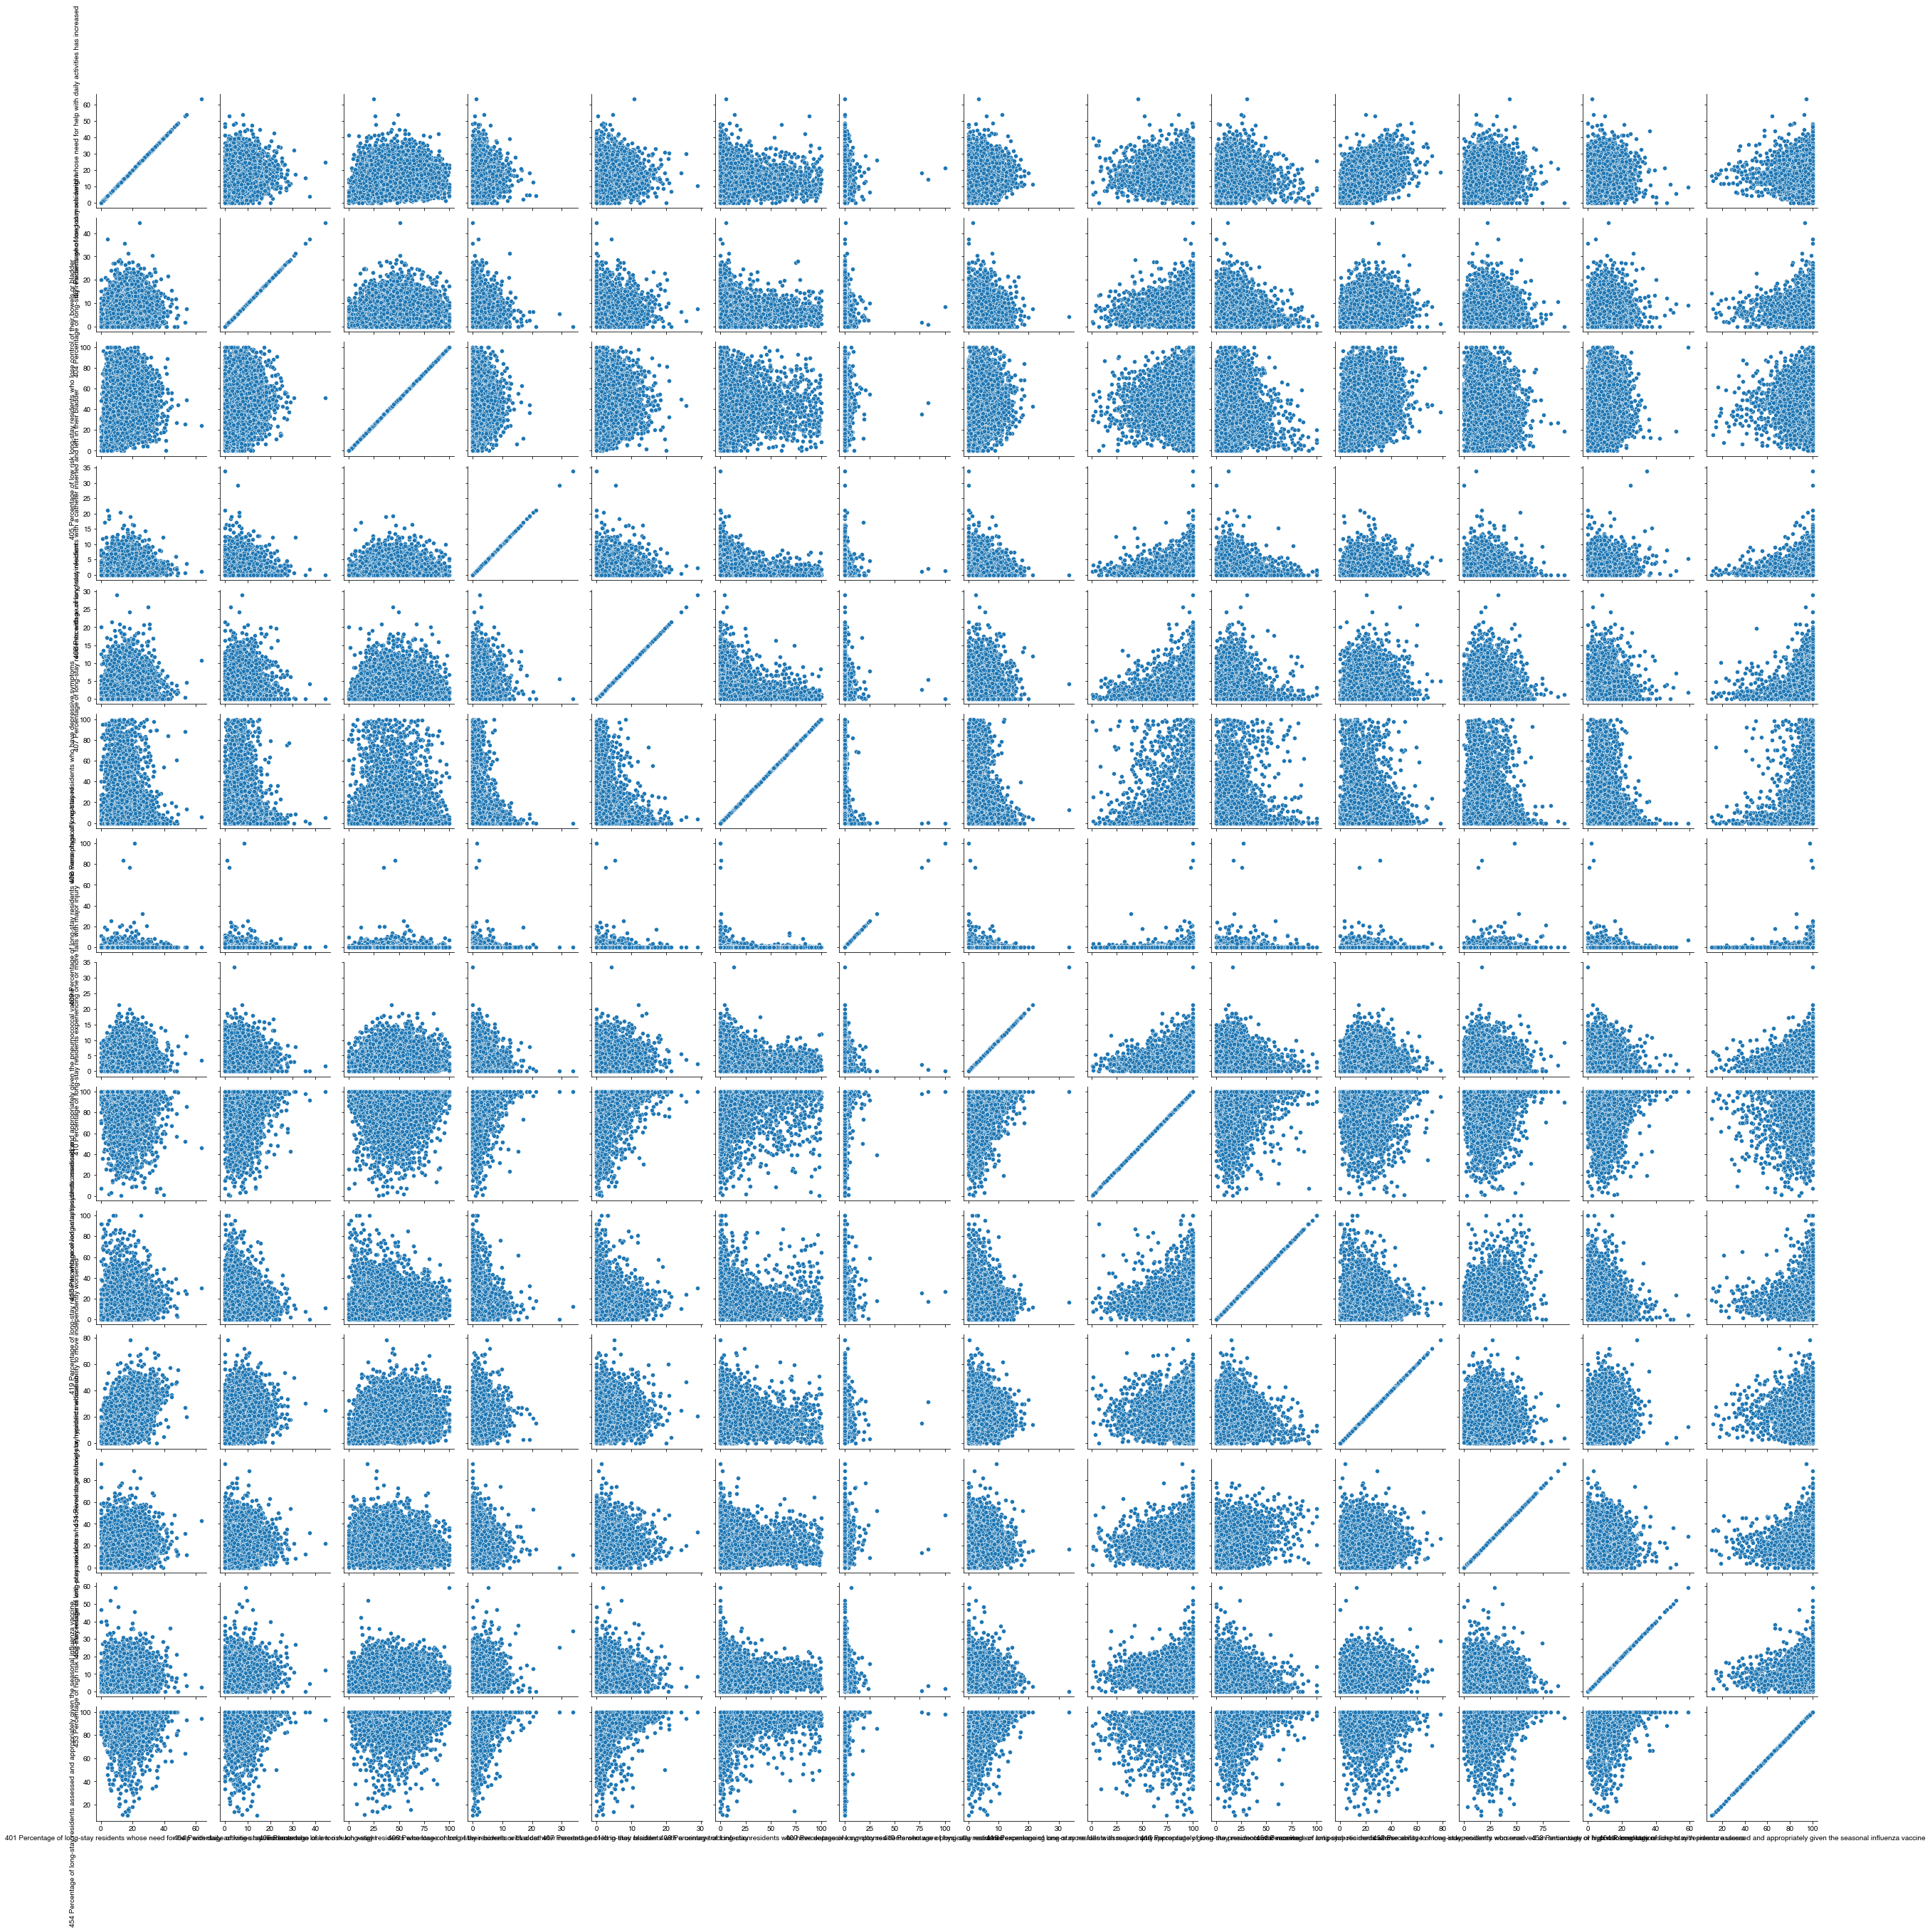

In [363]:
g = sn.PairGrid(all_measures)
g.map(sn.scatterplot)

# All Measures Analysis

In [384]:
all_measures.corr()

401 Percentage of long-stay residents whose need for help with daily activities has increased  \
401 Percentage of long-stay residents whose nee...                                           1.000000                                               
404 Percentage of long-stay residents who lose ...                                           0.146188                                               
405 Percentage of low risk long-stay residents ...                                           0.066138                                               
406 Percentage of long-stay residents with a ca...                                           0.082351                                               
407 Percentage of long-stay residents with a ur...                                           0.109481                                               
408 Percentage of long-stay residents who have ...                                          -0.003205                                               
409 Percentage of long-stay residents who were ...                                           0.013207                                               
410 Percentage of long-stay residents experienc...                                           0.121693                                               
415 Percentage of long-stay residents assessed ...                                          -0.171278                                               
419 Percentage of long-stay residents who recei...                                           0.102073                                               
451 Percentage of long-stay residents whose abi...                                           0.587954                                               
452 Percentage of long-stay residents who recei...                                           0.087092                                               
453 Percentage of high risk long-stay residents...                                           0.082140                                               
454 Percentage of long-stay residents assessed ...                                          -0.119260                                               
Provider Zip Code                                                                           -0.134885                                               
Number of Certified Beds                                                                    -0.026411                                               
Average Number of Residents per Day                                                         -0.043203                                               
Overall Rating                                                                              -0.202609                                               
Health Inspection Rating                                                                    -0.102074                                               
Staffing Rating                                                                             -0.116696                                               
RN Staffing Rating                                                                          -0.096049                                               
Reported Nurse Aide Staffing Hours per Resident...                                          -0.102670                                               
Reported LPN Staffing Hours per Resident per Day                                            -0.030384                                               
Reported RN Staffing Hours per Resident per Day                                             -0.098499                                               
Reported Licensed Staffing Hours per Resident p...                                          -0.105522                                               
Reported Total Nurse Staffing Hours per Residen...                                          -0.124347                                               
Reported Physical Therapist S

In [450]:
test.corrwith(test['419 Percentage of long-stay residents who received an antipsychotic medication'])

401 Percentage of long-stay residents whose need for help with daily activities has increased            0.105720
404 Percentage of long-stay residents who lose too much weight                                           0.020738
405 Percentage of low risk long-stay residents who lose control of their bowels or bladder              -0.100859
406 Percentage of long-stay residents with a catheter inserted and left in their bladder                 0.061472
407 Percentage of long-stay residents with a urinary tract infection                                     0.091257
408 Percentage of long-stay residents who have depressive symptoms                                       0.073052
409 Percentage of long-stay residents who were physically restrained                                     0.057117
410 Percentage of long-stay residents experiencing one or more falls with major injury                   0.084565
415 Percentage of long-stay residents assessed and appropriately given the pneumococcal 

In [437]:
all_measures.shape

(15139, 59)

In [396]:
all_measures.columns

Index(['Federal Provider Number', 'Provider Name',
       '401 Percentage of long-stay residents whose need for help with daily activities has increased',
       '404 Percentage of long-stay residents who lose too much weight',
       '405 Percentage of low risk long-stay residents who lose control of their bowels or bladder',
       '406 Percentage of long-stay residents with a catheter inserted and left in their bladder',
       '407 Percentage of long-stay residents with a urinary tract infection',
       '408 Percentage of long-stay residents who have depressive symptoms',
       '409 Percentage of long-stay residents who were physically restrained',
       '410 Percentage of long-stay residents experiencing one or more falls with major injury',
       '415 Percentage of long-stay residents assessed and appropriately given the pneumococcal vaccine',
       '419 Percentage of long-stay residents who received an antipsychotic medication',
       '451 Percentage of long-stay residents

In [486]:
all_m = all_measures[all_measures['452 Percentage of long-stay residents who received an antianxiety or hypnotic medication'].notna()]

In [487]:
all_m.corrwith(test['452 Percentage of long-stay residents who received an antianxiety or hypnotic medication'])

401 Percentage of long-stay residents whose need for help with daily activities has increased            0.086142
404 Percentage of long-stay residents who lose too much weight                                           0.047499
405 Percentage of low risk long-stay residents who lose control of their bowels or bladder              -0.137562
406 Percentage of long-stay residents with a catheter inserted and left in their bladder                -0.012739
407 Percentage of long-stay residents with a urinary tract infection                                     0.073698
408 Percentage of long-stay residents who have depressive symptoms                                       0.039373
409 Percentage of long-stay residents who were physically restrained                                     0.065081
410 Percentage of long-stay residents experiencing one or more falls with major injury                   0.091785
415 Percentage of long-stay residents assessed and appropriately given the pneumococcal 

In [ ]:
all_m = all_m[['401 Percentage of long-stay residents whose need for help with daily activities has increased',
       '404 Percentage of long-stay residents who lose too much weight',
       '405 Percentage of low risk long-stay residents who lose control of their bowels or bladder',
       '406 Percentage of long-stay residents with a catheter inserted and left in their bladder',
       '407 Percentage of long-stay residents with a urinary tract infection',
       '408 Percentage of long-stay residents who have depressive symptoms',
       '409 Percentage of long-stay residents who were physically restrained',
       '410 Percentage of long-stay residents experiencing one or more falls with major injury',
       '415 Percentage of long-stay residents assessed and appropriately given the pneumococcal vaccine',
       '419 Percentage of long-stay residents who received an antipsychotic medication',
       '451 Percentage of long-stay residents whose ability to move independently worsened',
       '452 Percentage of long-stay residents who received an antianxiety or hypnotic medication',
       '453 Percentage of high risk long-stay residents with pressure ulcers',
       '454 Percentage of long-stay residents assessed and appropriately given the seasonal influenza vaccine',
       'Provider City',
       'Provider State',
       'Ownership Type', 'Number of Certified Beds',
       'Average Number of Residents per Day', 'Provider Type',
       'Provider Resides in Hospital',
       'Continuing Care Retirement Community', 'Special Focus Status',
       'Abuse Icon', 'Most Recent Health Inspection More Than 2 Years Ago',
       'Provider Changed Ownership in Last 12 Months',
       'With a Resident and Family Council', 'Overall Rating',
       'Health Inspection Rating', 'Staffing Rating', 'RN Staffing Rating',
       'Reported Nurse Aide Staffing Hours per Resident per Day',
       'Reported LPN Staffing Hours per Resident per Day',
       'Reported RN Staffing Hours per Resident per Day',
       'Reported Licensed Staffing Hours per Resident per Day',
       'Reported Total Nurse Staffing Hours per Resident per Day',
       'Reported Physical Therapist Staffing Hours per Resident Per Day',
       'Case-Mix Nurse Aide Staffing Hours per Resident per Day',
       'Case-Mix LPN Staffing Hours per Resident per Day',
       'Case-Mix RN Staffing Hours per Resident per Day',
       'Case-Mix Total Nurse Staffing Hours per Resident per Day',
       'Adjusted Nurse Aide Staffing Hours per Resident per Day',
       'Adjusted LPN Staffing Hours per Resident per Day',
       'Adjusted RN Staffing Hours per Resident per Day',
       'Adjusted Total Nurse Staffing Hours per Resident per Day',
       'Number of Facility Reported Incidents',
       'Number of Substantiated Complaints',
       'Number of Citations from Infection Control Inspections',
       'Number of Fines', 'Total Amount of Fines in Dollars',
       'Total Number of Penalties']]

# Model Creation

In [739]:
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [712]:
y = all_m['452 Percentage of long-stay residents who received an antianxiety or hypnotic medication']
X = all_m.drop('452 Percentage of long-stay residents who received an antianxiety or hypnotic medication', axis = 1)

In [698]:
print(y.shape)
print(X.shape)

(14705,)
(14705, 50)


In [699]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=12)

In [700]:
print(all_m.shape)
print(X_test.shape)
print(X_train.shape)

(14705, 51)
(4412, 50)
(10293, 50)


## Linear Regression

In [703]:
pipe = Pipeline([('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                 ('linear_model', linear_model.LinearRegression())])

In [635]:
param_grid = {
    "select_best__k": [15, 30, 45, 60, 75, 90, 105],
}
search = GridSearchCV(pipe, param_grid, n_jobs=2)
search.fit(X_test, y_test)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

/Users/jenniferfaith/.local/share/virtualenvs/cms_2022-Pd6xfLBt/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/jenniferfaith/.local/share/virtualenvs/cms_2022-Pd6xfLBt/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/Users/jenniferfaith/.local/share/virtualenvs/cms_2022-Pd6xfLBt/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/jenniferfaith/.local/share/virtualenvs/cms_2022-Pd6xfLBt/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, Us

/Users/jenniferfaith/.local/share/virtualenvs/cms_2022-Pd6xfLBt/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/jenniferfaith/.local/share/virtualenvs/cms_2022-Pd6xfLBt/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/Users/jenniferfaith/.local/share/virtualenvs/cms_2022-Pd6xfLBt/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/jenniferfaith/.local/share/virtualenvs/cms_2022-Pd6xfLBt/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, Us

/Users/jenniferfaith/.local/share/virtualenvs/cms_2022-Pd6xfLBt/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/jenniferfaith/.local/share/virtualenvs/cms_2022-Pd6xfLBt/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/Users/jenniferfaith/.local/share/virtualenvs/cms_2022-Pd6xfLBt/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/jenniferfaith/.local/share/virtualenvs/cms_2022-Pd6xfLBt/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, Us

Best parameter (CV score=-0.001):
{'select_best__k': 45}


In [704]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('linear_model', LinearRegression())])

In [705]:
y_train_pred = pipe.predict(X_train)

In [706]:
y_test_pred = pipe.predict(X_test)

In [707]:
print(mean_absolute_error(y_train, y_train_pred))
print(mean_absolute_error(y_test, y_test_pred))

0.0005147657601217634
6.900826251290364


In [708]:
diff = pd.DataFrame(list(zip(y_test, y_pred)), columns = ['y_test', 'y_pred'])

<AxesSubplot:>

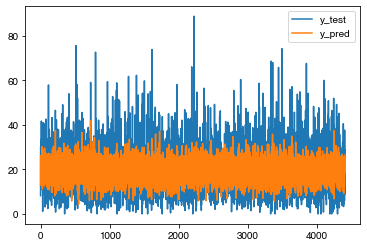

In [709]:
diff.plot()

## Gradient Boosting

In [713]:
pipe = Pipeline([('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                 ('linear_model', GradientBoostingRegressor(random_state=0))])

pipe.fit(X_train, y_train)
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)
print(mean_absolute_error(y_train, y_train_pred))
print(mean_absolute_error(y_test, y_test_pred))

6.857853653861271
7.021379493497376


## Ridge Regression

In [736]:
pipe = Pipeline([('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                 ('linear_model', Ridge(alpha=8.0))])

pipe.fit(X_train, y_train)
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)
print(mean_absolute_error(y_train, y_train_pred))
print(mean_absolute_error(y_test, y_test_pred))

1.6468005953171385
6.873182350242403


## Lasso Regression

In [738]:
pipe = Pipeline([('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                 ('linear_model', linear_model.Lasso(alpha=0.1))])

pipe.fit(X_train, y_train)
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)
print(mean_absolute_error(y_train, y_train_pred))
print(mean_absolute_error(y_test, y_test_pred))

7.289964747302822
7.305445108914532


## Random Forrest Regression

In [741]:
pipe = Pipeline([('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                 ('forest_model', RandomForestRegressor())])

pipe.fit(X_train, y_train)
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)
print(mean_absolute_error(y_train, y_train_pred))
print(mean_absolute_error(y_test, y_test_pred))

2.5409292804321386
7.002868249667704
